In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
# === Load train dataset only === #
project = Path.cwd()
target_folder = project / "0 - data"
train_df = pd.read_excel(target_folder / "train_clean.xlsx", sheet_name="Sheet1")

In [ ]:
# === Define target + features === #
target_col = "Automation Suitable"
drop_cols = ["Task ID", "Task Name"]
drop_cols = [c for c in drop_cols if c in train_df.columns]

X_train = train_df.drop(columns=[target_col] + drop_cols)
y_train = train_df[target_col]

In [ ]:
# === Preprocessing (OneHot + passthrough) === #
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

In [ ]:
# === Build Base model (Support Vector Machine) === #
svm_base_model = SVC(
    kernel="linear",
    C=1.0,
    probability=True,
    class_weight="balanced",
    random_state=42
)

base_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", svm_base_model)
])

base_pipeline.fit(X_train, y_train)
print("✅ Support Vector Machine BASE model trained.")

✅ Support Vector Machine BASE model trained.



=== Top 3 for model__C ===
  10.0  ->  CV mean=0.8450 (±0.0232)
  1000.0  ->  CV mean=0.8400 (±0.0255)
  100.0  ->  CV mean=0.8375 (±0.0209)


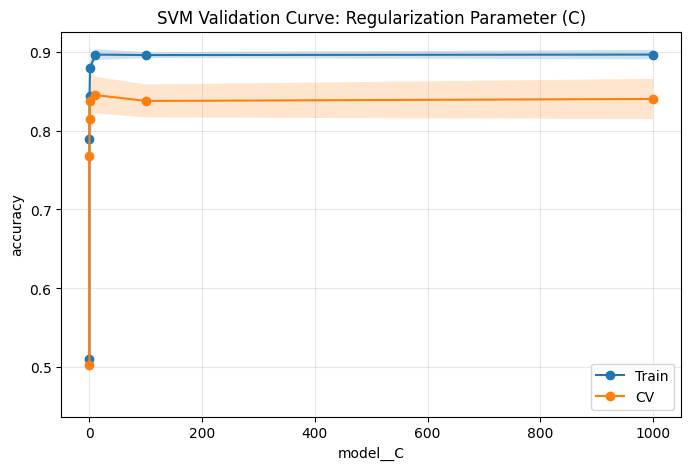

In [ ]:
# === Plot Validation Curve === #
def plot_validation_curve_top3(
    pipeline,
    X_train,
    y_train,
    param_name: str,
    param_range,
    title: str,
    scoring: str = "accuracy",
    cv: int = 5
):
    train_scores, val_scores = validation_curve(
        pipeline,
        X_train,
        y_train,
        param_name=param_name,
        param_range=param_range,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    top3_idx = np.argsort(val_mean)[-3:][::-1]
    print(f"\n=== Top 3 for {param_name} ===")
    for i in top3_idx:
        print(f"  {param_range[i]}  ->  CV mean={val_mean[i]:.4f} (±{val_std[i]:.4f})")

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, marker="o", label="Train")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(param_range, val_mean, marker="o", label="CV")
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

C_range = np.logspace(-3, 3, 7)

plot_validation_curve_top3(
    base_pipeline,
    X_train, y_train,
    param_name="model__C",
    param_range=C_range,
    title="SVM Validation Curve: Regularization Parameter (C)",
    scoring="accuracy",
    cv=5
)

In [ ]:
# === Hyperparameter tuning (Random Forest) === #
param_grid = {
    "model__C": [10.0, 1000.0, 100.0]
}

svm_search = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1,
    refit=True
)

svm_search.fit(X_train, y_train)

print("\n✅ SVM tuning complete.")
print("Best CV Accuracy:", round(svm_search.best_score_, 4))
print("Best Params:", svm_search.best_params_)

tuned_pipeline = svm_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits



✅ SVM tuning complete.
Best CV Accuracy: 0.845
Best Params: {'model__C': 10.0}


In [ ]:
# === Save BASE + TUNED models === #
bundle = {
    "base": base_pipeline,
    "tuned": tuned_pipeline,
    "best_model": tuned_pipeline,
    "best_params": svm_search.best_params_,
    "best_cv_score": float(svm_search.best_score_),
    "meta": {
        "model_name": "Support Vector Machine",
        "kernel": "linear",
        "search_type": "GridSearchCV",
        "scoring": "accuracy",
        "cv_folds": 5
    }
}

save_path = "2 - models/support_vector_machine_model.pkl"
joblib.dump(bundle, save_path)

print(f"✅ BASE + TUNED SVM models saved to: {save_path}")

✅ BASE + TUNED SVM models saved to: 2 - models/support_vector_machine_model.pkl
